In [1]:
import graphviz
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.tree import export_graphviz, DecisionTreeRegressor
from src.poisson_boosting import GradientBoostingPoissonRegressor

plt.style.use('bmh')

# Boosting Pair Assignment

This pair assignment will push our understanding of Gradient Boosting further.  We have already discussed Gradient Boosted Regression and Gradient Boosted Logistic Regression (called `GradientBoostingClassifier` in sklearn).  In this assignment we will be implementing another type of gradient boosting: Gradient Boosted Poisson Regression.


## The Overall Idea

Let's summarize the idea behind the two types of gradient boosting we have studied so far.  Our first type of gradient boosting, Gradient Boosted Regression, proceeded by fitting regression trees to residuals in a stagewise <sup>[1](#stagewise)</sup> manner. 

Lets use the symbol `f` to stand in for the stack of regression trees we would like to grow:

`f(X) = T_0(X) + T_1(X) + ... + T_n(X)`

And we can express what we did in the classification case (i.e. Gradient Boosted Logistic Regression) as

```python
y | X ~ Bernoulli(p = logistic(f(X)))
```

This equation expresses a model <sup>[2](#statistical-model)</sup> for *how our data may have been generated*  To *fit* the model, we maximize the log-likelihood (i.e. use the maximum likelihood method), just like in regular old linear and logistic regression.

Gradient Boosted Poisson Regression is very similar, but with the following data model

```python
y | X ~ Poisson(lambda = exp(f(X)))
```

This means that, once we know `X` for a given data point, we can compute a prediction as `exp(sum of regression trees)`. Our interpretation of this prediction is as the rate parameter in a Poisson distribution, and we are positing that the value of `y` associated with the data point was drawn from a Poisson distribution with this rate parameter.


## Simulating Data

Poisson models are appropriate for data in which the target `y` is a *count*.  To demonstrate, we will first build a simple dataset of data for which a Poisson model is appropriate.  The idea is already contained in our expression

```python
y | X ~ Poisson(lambda = exp(f(X)))
```

above.

1. Simulate an array `X` containing 1000 data points uniformly distributed between `-4pi` and `4pi` using `np.uniform`.

In [2]:
r = np.random.RandomState(237)
X = r.uniform(low=-4*np.pi, high=4*np.pi, size=1000)

2. Make a plot of the exponential of the function below, its chosen to have an interesting shape (it's very non-linear).

In [3]:
f = lambda t: 2 * (1 - np.abs(t)/(4*np.pi)) * np.abs(np.cos(t))

3. Create a vector `log_rate` as `f(X)`, this will serve as a ground truth for our model during testing.

In [4]:
log_rate = f(X)

4. Create a target array `y`, where each entry of `y` is drawn from a Poisson distribution, and the rate parameter for the Poisson distribution is the exponential of the corresponding entry of `f(x)`.  More precisely 

```python
y_i = sample_from_poisson_distribution(rate = exp(f(X_i)))
```

In [5]:
r = np.random.RandomState(245)
y = r.poisson(lam=np.exp(f(X)))

5. Superimpose a scatter plot of your `y` data vs. `X` on your plot of the function `exp(f)`.  It should look something like this:

![Ground Truth and Data](images/poisson-data.png)

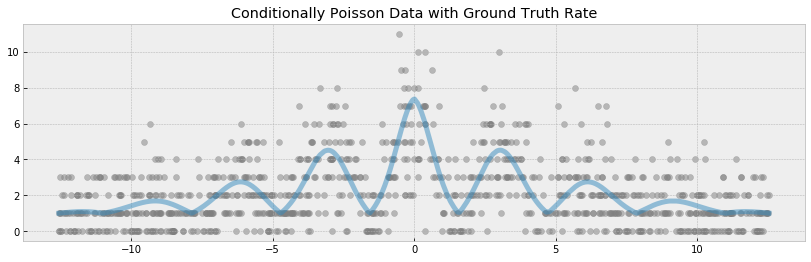

In [6]:
fig, ax = plt.subplots(figsize=(14, 4))
ax.scatter(X, y, c='grey', alpha=0.5)

sorted_idx = np.argsort(X)
ax.plot(X[sorted_idx], np.exp(f(X))[sorted_idx], alpha=0.5, lw=5)

ax.set_title('Conditionally Poisson Data with Ground Truth Rate')

plt.show()

## Exploring the DecisionTreeRegressor Object

To implement our boosting model we are going to need a better understanding of how `sklearn`'s `DecisionTreeRegressor` object works.  We are going to change how predictions are generated for each tree in our booster, and this will necessitate knowing which observations in a data set end up in which terminal node.  The `apply` method is the tool for accomplishing this.

1. Read the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.apply) for `DecisionTreeRegressor.apply`.  Form a hypothesis about what the method does, and how it work.

The `DecisionTreeRegressor.apply()` method returns the index of the leaf that each sample is predicted as.
It returns a list of the indices of the leaves where each data point is placed by the tree.

2. Fit a `DecisionTreeRegressor` to the dataset you generated above, using `max_depth=3`.  Call the `apply` method on your training data: `leaves = fit_decision_tree.apply(X)`.  Are the results consistent with your hypothesis?

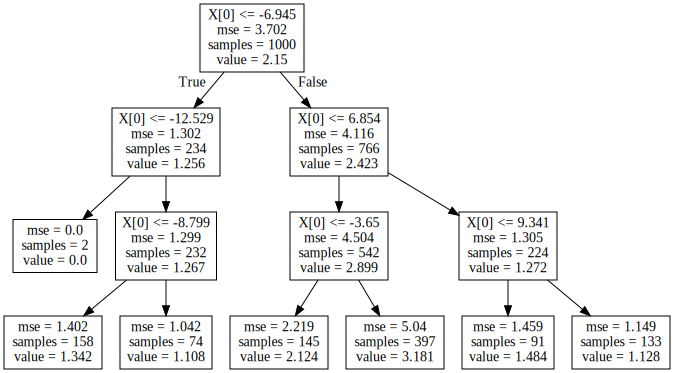

In [7]:
fit_decision_tree = DecisionTreeRegressor(max_depth=3, random_state=1555)
fit_decision_tree.fit(X.reshape(-1, 1), y.reshape(-1, 1))

graph = graphviz.Source(export_graphviz(fit_decision_tree))
graph.format = 'dot'
graph.render('images/tree')

graph.format = 'png'
graph.render('images/tree')

graph

![Decision Tree](images/tree.png)

In [8]:
leaves = fit_decision_tree.apply(X.reshape(-1, 1))

Each data point from `X` corresponds to a value in `leaves`.

In [9]:
print(leaves.shape)
print(X.shape)

(1000,)
(1000,)


We created a binary decision tree of depth = 3 that can have $2^{3}$ = 8 maximum leaf nodes. This decision tree has 7 leaf nodes which is consistent with our hypothesis.

In [10]:
print(np.unique(leaves))
len(np.unique(leaves))

[ 2  4  5  8  9 11 12]


7

3. Concatenate the `leaves` array with a predictions array (`fit_decision_tree.predict(X)`) to create a two column matrix.  Take a look at the first 100 rows of this matrix, and make note of any patterns you observe.  What is the relationship between the predictions from the tree that share the same value of `leaves`?

Within a leaf, predictions are the same.

In [11]:
preds = fit_decision_tree.predict(X.reshape(-1, 1))
leaves_predict = np.concatenate([leaves.reshape(-1, 1), preds.reshape(-1, 1)], axis=1)
print(leaves_predict[:10])

[[12.          1.12781955]
 [ 8.          2.12413793]
 [ 4.          1.34177215]
 [11.          1.48351648]
 [ 5.          1.10810811]
 [12.          1.12781955]
 [ 9.          3.1813602 ]
 [ 9.          3.1813602 ]
 [ 9.          3.1813602 ]
 [ 9.          3.1813602 ]]


4. Create a `pandas.DataFrame` containing `y`, `preds`, and `leaves` as columns.  Calculate the column means grouped by `leaves`.  What do you observe?

$pred_{leaf}$ = mean($y_{leaf}$)  
Using the features(X) of an observation, a Decision Tree follows a path to a specific leaf.  Then then decision tree prediction for the observation is the mean of the y values in the training set that fell into that leaf.

In [12]:
d = {'y': y, 'preds': preds, 'leaves': leaves}
df = pd.DataFrame(d)
display(df.groupby('leaves').mean())

,y,preds
leaves,,
2,0.000000,0.000000
4,1.341772,1.341772
5,1.108108,1.108108
8,2.124138,2.124138
9,3.181360,3.181360
11,1.483516,1.483516
12,1.127820,1.127820


5. What is the `leaves` array?  How could you manually calculate the predictions from the Decision Tree?  If you have some need to *change how the predictions were calculated in each leaf*, how would you do so?

The `leaves` array is the array of node indices of the leaves: for a depth of 3, the maximum number of nodes is 15 including the root node, branch nodes and leaf nodes.

To manually calculate the predictions of the tree, we need to apply the decision criterion of the top node to choose the next node 1 level below and repeat the process until we end on a leaf, and return the mean of the target of samples in the leaf as the prediction.

Sklearn's DecisionTreeRegressor does not offer an option to change the way the predictions are made in leaves. One way to work around the limitation is to:

- Create a separate dictionary of leaf predictions for each tree with node_id:prediction as key:value pairs (terminal_node_estimates in next section)
- Use that dictionary together with DecisionTreeRegressor `.apply()` to make predictions

## Implementing a Poisson Gradient Booster

Our goal in this section is to write our own implementation of Poisson boosting (an algorithm that is *not* included in sklearn, so this is not an idle task!).  In `poisson_booster.py` we have supplied a stub class that you can use to get started.  The documentation strings in this file contain lots of details on the algorithm, so be sure to read them carefully.  In particular, make sure to pay attention to the descriptions of the arguments and return values of the methods in the class.

1. Read the `__init__` method, and make note of the attributes an object of type `GradientBoostingPoissonRegressor` has.  The class is written carefully so that all attributes of an object are created in `__init__` <sup>[3](#init)</sup>.  If they have no value at the time an object is created, they are set to `None` or empty collections (an empty list, for example).

2. Read all of the docstrings in `GradientBoostingPoissonRegressor`.  Don't worry about getting all the details, you're just looking to get an overview of what the class is supposed to do and where the various pieces of the logic will go.

3. Fill in the `fit` method.  Feel free to *call* any other methods of the class you need, even though you have not yet implemented them.  It may feel strange to write code that calls a function even if you have not written the function yet, but this *top down* style of programming is very useful.  It is generally less mental burden to work from high level details to low level details, as opposed to the other direction.

If you get stuck, feel free to move on to implementing the other methods in the class, and come back to implementing `fit`.

4. Using a top down style of programming, implement `predict`.  Again, if you get stuck, feel free to move on to other methods, and come back to finish this later.

5. Fill in the `_initial_value` method.

6. Fill in `_gradient` method according to the description in the docstring.

7. Fill in the `_terminal_node_estimates` method.  This is probably the most difficult method to implement, as it involves a rather intimate interaction with a fit regression tree object.  You will need to use the familiarity you have built with the `tree.apply` method. 

8. Fill in the `_prediction_update` method.  You will need to use `tree.apply` again here.

9. Go back and finish implementing `fit` and `predict`, if necessary.


## Testing Your Implementation

1. Import your completed class into a notebook, and create a `GradientBoostingPoissonRegressor` object.

In [13]:
fit_decision_tree = GradientBoostingPoissonRegressor(learning_rate=0.01, n_estimators=2000)

2. Fit the model to the data you simulated before.

In [14]:
fit_decision_tree.fit(X.reshape(-1, 1), y)

3. Create a `np.linspace` between `-4pi` and `4pi`, and make predictions for each data point in this linspace.  Plot these predicted values superimposed on your plot of the ground truth and data from before.  Your results should look something like this:

![Ground Truth, Predicted Values, and Data](images/poisson-predictions.png)

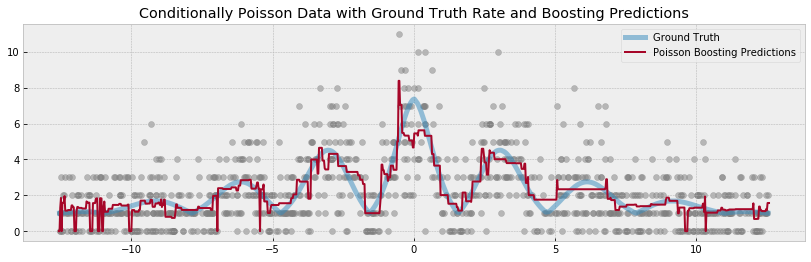

In [15]:
X_for_pred = np.linspace(-4 * np.pi, 4 * np.pi, num=1000).reshape(-1, 1)
y_pred = fit_decision_tree.predict(X_for_pred)

fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(X, y, c='grey', alpha=0.5)

sorted_idx = np.argsort(X)
ax.plot(X[sorted_idx], np.exp(f(X)[sorted_idx]), alpha=0.5, label='Ground Truth', lw=5)
ax.plot(X_for_pred, y_pred, label='Poisson Boosting Predictions')

ax.set_title('Conditionally Poisson Data with Ground Truth Rate and Boosting Predictions')
ax.legend()

plt.show()

Congratulations!  You have implemented gradient boosting from scratch!

<a name="stagewise">1</a> That is, we start with a simple model, fit a regression tree to the residuals of that model, then add the predictions from this tree to the predictions of our previous model, get new residuals, and iterate.  Since regression trees minimize the squared error, we have essentially stacked regression trees to *greedily* minimize the squared error.

<a name="statistical-model">2</sup>: By *statistical model* we mean *a specification for how our data may have been generated*.  More precisely, following [Wasserman](http://www.springer.com/us/book/9780387402727), a statistical model is a collection of random variables, at least one of which we believe may have (approximately) generated our training data.

<a name="init">3</sup>: Creating all attributes in `__init__` is generally a good practice.  In python 3, it results in more efficient code, since memory for all the attributes is allocated when the object is created.